In [1]:
import refitter as rf
reload(rf)

import ROOT as RT
# RT.gROOT.LoadMacro("~/rootlogon.C")
RT.gStyle.SetOptStat(0)
RT.gStyle.SetPalette(RT.kViridis)
import numpy as np

import pyrapp as pya
reload(pya)
app = pya.PyRApp([],args=["-O","plots"])
app.options.saveas=["root","pdf"]
def save(obj):
    app.keep(obj,format=True)
    app.save(True)

import os
    
#%jsroot on
%jsroot off

ERROR:root:Line magic function `%jsroot` not found.


Welcome to ROOTaaS 6.06/08
[Errno 17] File exists: 'plots'


In [2]:
inputDir=os.path.expanduser("root://t3dcachedb03.psi.ch//pnfs/psi.ch/cms/trivcat/store/user/musella/mod_dep_005/")

eff = rf.ProcessHistos("Eff",inputDir+"/output_InsideAcceptance_125.root",
                      "hpty",
                      "genPt:abs(genRapidity)","(30,0.,3,30,0,300)","abs(weight)",3,
                      doOverall=True
                     )


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt


Eff
genPt:abs(genRapidity)>>hptyEff_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyEff_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyEff_2(30,0.,3,30,0,300)


Info in <TCanvas::SaveAs>: ROOT file plots/efficiency.root has been created
Info in <TCanvas::Print>: pdf file plots/efficiency.pdf has been created


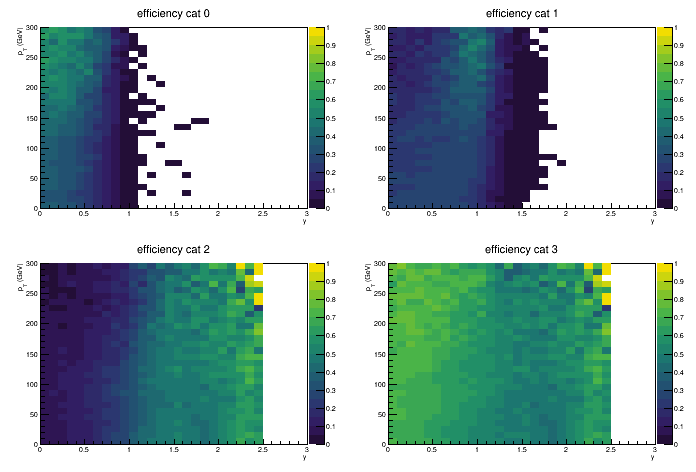

Info in <TCanvas::SaveAs>: ROOT file plots/efficiency.root has been created
Info in <TCanvas::Print>: pdf file plots/efficiency.pdf has been created


In [3]:
#%jsroot on
eff.computeEfficiencies()

canv=rf.drawHists(eff,htitle="efficiency cat %d; y;p_{T} (GeV)",nplots=-1,name="efficiency")
save(canv)

In [5]:
sm = rf.ProcessHistos("SM",inputDir+"/output_InsideAcceptance_125.root",
                      "hpty",
                      "genPt:abs(genRapidity)","(30,0.,3,30,0,300)","weight",3,
                     doOverall=True)

smoa = rf.ProcessHistos("SM_OA",inputDir+"/output_OutsideAcceptance_125.root",
                      "hpty",
                      "genPt:abs(genRapidity)","(30,0.,3,30,0,300)","weight",3,
                      treepfx="genDiphotonDumper/trees/OutsideAcceptance_125_13TeV",  
                    )



SM
genPt:abs(genRapidity)>>hptySM_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptySM_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptySM_2(30,0.,3,30,0,300)


ReferenceError: attempt to access a null-pointer

Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3011] No such file



In [ ]:
num = sm.genHist.Clone("num")
den = sm.genHist.Clone("den")
den.Add(smoa.genHist)
num.Divide(num,den,1.,1.,"b")
acc=num

In [ ]:
canv=RT.TCanvas("acceptance","acceptance")
canv.Divide(2,2)
canv.cd(1)
sm.genHist.Draw("colz")
canv.cd(2)
smoa.genHist.Draw("colz")
canv.cd(3)
den.Draw("colz")
canv.cd(4)
acc.GetZaxis().SetRangeUser(0.,1.)
acc.Draw("colz")
canv.Draw()

denpt=den.ProjectionY()
denpt.SetLineColor(RT.kRed)
fidpt=sm.genHist.ProjectionY()
denpt.SetLineColor(RT.kBlue)

deny=den.ProjectionX()
deny.SetLineColor(RT.kRed)
fidy=sm.genHist.ProjectionX()
deny.SetLineColor(RT.kBlue)

canv2=RT.TCanvas("acceptance1D","accepance1D")
canv2.Divide(2,1)
canv2.cd(1)
denpt.Draw("hist")
fidpt.Draw("hist same")
canv2.cd(2)
deny.Draw("hist")
fidy.Draw("hist same")

canv2.Draw()
save([canv,canv2])

In [ ]:

meas = [[ 0.4800, +0.3792, -0.3265,],
        [ 0.7600, +0.32, -0.4451,],
        [ 1.1050, +0.578, -0.623,],]


data=rf.DataRecord( np.array(map(lambda x: x[0], meas )), 
                    np.array(map(lambda x: (x[1]+abs(x[2]))*0.5, meas )),
                    None
                     )

fitter = rf.Fitter(data,eff,sm)

In [ ]:
fitter.fitModel(sm)

In [ ]:
sm_procs = map(lambda x: rf.ProcessHistos(x,inputDir+"/output_InsideAcceptance_%s_125.root" %x,
                      "hpty",
                      "genPt:abs(genRapidity)","(30,0.,3,30,0,300)","weight",3,
                     ),  ["ggF","VBF","VH","ttH"] )

In [ ]:
from pprint import pprint
pprint(map(fitter.fitModel,sm_procs))

In [ ]:
sm_ooa = map(lambda x: rf.ProcessHistos(x,inputDir+"/output_OutsideAcceptance_%s_125.root" %x,
                    "hpty",
                    "genPt:abs(genRapidity)","(30,0.,3,30,0,300)","weight",3,
                    treepfx="genDiphotonDumper/trees/OutsideAcceptance_125_13TeV"
                     ),  ["ggF","VBF","VH","ttH"] )



In [ ]:
pprint(map(lambda x: map(lambda y: (y[0].GetName(),y[1].Integral()/y[0].Integral()), 
                  zip(x[0].hists,x[1].hists)) , zip(sm_procs,sm_ooa) ))

In [ ]:
sm_weights = np.array(map(lambda x: fitter.fitEfficiencies(x,True).bias, 
        [np.array([1.,0.,0.]), 
         np.array([0.,1.,0.]),
         np.array([0.,0.,1.])
        ]))

#sm_effs = np.array(sm.predictYields(eff,True)[:sm.ncats])

In [ ]:
from copy import deepcopy
weights_map = deepcopy(eff)

weights_map.hists = weights_map.hists[:weights_map.ncats]
map(lambda x: x[0].Scale(x[1]*weights_map.ncats),zip(weights_map.hists,sm_weights))

weights_map.hists.append(rf.mergeHists(weights_map.hists[:weights_map.ncats]))

In [ ]:
canv=rf.drawHists(weights_map,htitle="effective efficiency cat %d;p_{T} (GeV); y",nplots=-1,name="weighted_eff")
save(canv)
print(sm_weights)

In [ ]:
fitter.refEffs.sum()